# Summarization Using Deep Learning Prototype

This notebook is a prototype of trying to use deep learning for automatic extractive text summarization. To simplify the problem I have made the following assumptions. 

- The input article is 30 sentences or less.
- A labeled dataset will be created by choosing up to the top 3 sentences that maximize the rouge score.
- The training task is to then automatically chose which sentences should be included in the summary. 
- The input is a list of sentences in the article, and 1 sentence from the article.
- The output is whether that sentence should be included in the summary or not. (1 or 0).
- To classify the entire document we will have to loop over each sentence to ask the model if it should be included or not. 

The structure for this model gets lots of ideas from this paper:

_SummaRuNNer: A Recurrent Neural Network based Sequence Model for
Extractive Summarization of Documents_

Ramesh Nallapati, Feifei Zhai, Bowen Zhou

https://arxiv.org/pdf/1611.04230.pdf


I have already made a clean dataset in the data cleaning notebook. So I can go ahead and load it. 

In [1]:
# run the following command if you don't have the spacy model downloaded yet.
# This must be done before you import spacy. https://spacy.io/models/en#en_core_web_sm
# ! python -m spacy download en_core_web_sm

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import *
import spacy
import pandas as pd
import os

In [3]:
#Params

article_train_limit = None # How many articles we allow to be trained.
max_article_length = 30
batch = 128
fine_tune_USE = False # Whether or not our we should allow additional training on the sentence embedder.
checkpoint_dir = 'tfmodel.spacy.average_pooling.class_weights'

data_dir = "spacy_fmeasure-1"
train_data = os.path.join(data_dir,'train.labeled.parquet')
validation_data = os.path.join(data_dir,'validation.labeled.parquet')
test_data = os.path.join(data_dir,'test.labeled.parquet')

# True means to balance data using number of samples
# False means to balance it using class weights
balance_data = False

In [4]:
df=pd.read_parquet('test.labeled.parquet')
df.columns

Index(['article', 'summary', 'sentences', 'labels', 'rouge'], dtype='object')

Here is a description of the columms

- **article** the original article.
- **summary** the summary from the dataset. 
- **sentences** an array with the article split into individual sentences
- **labels** array same length as `sents` identifying which sentences should be in the summary.
- **rouge** The rouge1 score for the 3 labels=1 sentences against the summary

In [5]:
# If the article is less than max_article_length, we need to pad and mask the empty sentences.
def make_mask(sents):
    length = len(sents)
    return ([True] * length) +([False] * (max_article_length-length))

# Just use empty strings to pad
def pad_sents(sents):
    length = len(sents)
    if not isinstance(sents, list):
        sents = sents.tolist()
    return sents + [""] * (max_article_length-length)

def explode_examples(parquet_file_name, article_train_limit=None, balance_data=True):
    df=pd.read_parquet(parquet_file_name)
    df['sent_count'] = df.sentences.map(lambda x: len(x))
    df = df[df.sent_count<=max_article_length].copy()

    df = df.iloc[0:article_train_limit].copy()
    df['mask'] = df.sentences.map(make_mask)

    # Here we pair the label and individual sentence then explode these into individual training examples.
    # This has the side effect of excluding the padded strings because the labels can be shorter than the
    # sentences. e.g. list(zip(['a','b','c'], [1,2])) ==  [('a', 1), ('b', 2)]    (Note no 'c')
    df['paired'] = df.apply(lambda x: list(zip(x.labels, x.sentences)), axis=1)
    df = df.explode('paired')
    df['label'] = df.paired.map(lambda x: x[0])
    df['sent'] = df.paired.map(lambda x: x[1])
    df['sentences'] = df.sentences.map(pad_sents)
    df = df[['sentences', 'sent', 'label', 'mask']]
    if balance_data:
        positive = df[df.label==1].shape[0]
        balanced = df[df.label==0].sample(frac=1).iloc[0:positive].copy()
        df = balanced.append(df[df.label==1].copy())
    df = df.sample(frac=1)
    
    x = {"article_sentences":tf.constant(df.sentences.values.tolist()), 
             "sent":tf.constant(df.sent.values.tolist()), 
             "mask": tf.constant(df['mask'].values.tolist())}
    y = tf.convert_to_tensor(df.label.values, dtype=tf.int8)
    return tf.data.Dataset.from_tensor_slices((x, y)).batch(batch, drop_remainder=True)

In [6]:
train_dataset = explode_examples(train_data, article_train_limit=article_train_limit, balance_data=balance_data)
validation_dataset = explode_examples(validation_data, balance_data=balance_data)

In [7]:
train_df = pd.read_parquet(train_data)
train_df['article_length'] = train_df.labels.map(len)
train_df = train_df[train_df.article_length <= max_article_length]
total_labels = train_df.article_length.sum()
total_pos = train_df.labels.map(sum).sum()
print(f'Porportion of positive examples {total_pos/total_labels}')
pos_weight = total_labels / (2 * total_pos)
neg_weight = total_labels / (2* (total_labels-total_pos))
class_weights = {0: neg_weight, 1: pos_weight}
if balance_data:
    class_weights = {0:1, 1:1}
class_weights

Porportion of positive examples 0.047206480999946204


{0: 0.5247726711289393, 1: 10.591765990787787}

In [8]:
train_dataset

<BatchDataset shapes: ({article_sentences: (128, 30), sent: (128,), mask: (128, 30)}, (128,)), types: ({article_sentences: tf.string, sent: tf.string, mask: tf.bool}, tf.int8)>

Here is the description of the transformed data

#### X
- **article_sentences** The sentences padded to a fixed length, this could be duplicated for as many sentences are in the article.
- **sent** The individual sentence for the training example
- **mask** To keep track of which sentences are just paddin

#### Y:
- **label** Whether or not this example should be included in the summary

## Model Graph

Below you can see the summary and image. 
For the forward pass we have the sentences that get embedded using Universal Sentence Encoder and then squashed into 1 vector using a GRU. 
Then the sentence to be classified is embedded using Universal Sentence encoder as well. 
These two vectors are concatenated and dense layers bring it down to 1 output. 

In [9]:
# This can take a minute to load.
# Loading this one multiple times sometimes causes errors. 
# If running the cells below multiple times and you get some weird un explainable error, restart
# the kernel to see if it helps. 

#If you get the error SavedModel file does not exist at: /var/folders/cl....
# Delete it ex: rm -r /var/folders/cl/63p3pg596jq18sjxn0zdb8k40000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c

use_embed_sent = hub.keras_layer.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", name="sent_embedder", trainable=fine_tune_USE)
use_embed_article_sentences = hub.keras_layer.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", name="article_sents_embedder", trainable=fine_tune_USE)

In [10]:
article_sentences = tf.keras.layers.Input(shape=[max_article_length],dtype=tf.string, name="article_sentences", ragged=False)
sent = tf.keras.layers.Input(shape=[], name='sent', dtype=tf.string)
mask = tf.keras.layers.Input(shape=[max_article_length], dtype=tf.bool, name="mask")
sent_reshaped = tf.reshape(sent, [-1], name="sent_reshaped")
sent_embed = use_embed_sent(sent_reshaped)
sent_embed_reshaped = tf.reshape(sent_embed, [-1,512], name="sent_embed_reshaped")
article_sentences_1d = tf.reshape(article_sentences, [-1], name="article_sentences_1d")
article_sentences_embed = use_embed_article_sentences(article_sentences_1d)
article_sentences_restored = tf.reshape(article_sentences_embed, [-1, max_article_length, 512], name="article_sentences_restored")
article_sentences_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512,name="gru", dropout=0.2))(article_sentences_restored, mask=mask)
concatenated = tf.concat([article_sentences_gru, sent_embed_reshaped], axis=1, name="concated")
d1 = layers.Dense(128, activation='relu')(concatenated)
d2 = layers.Dense(1, activation='sigmoid')(d1)
model = Model(inputs=[article_sentences, sent, mask], outputs=[d2])
model.compile(loss=losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()],
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
article_sentences (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_article_sentences_1 [(None,)]            0           article_sentences[0][0]          
__________________________________________________________________________________________________
sent (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
article_sents_embedder (KerasLa (None, 512)          256797824   tf_op_layer_article_sentences_1d[
______________________________________________________________________________________________

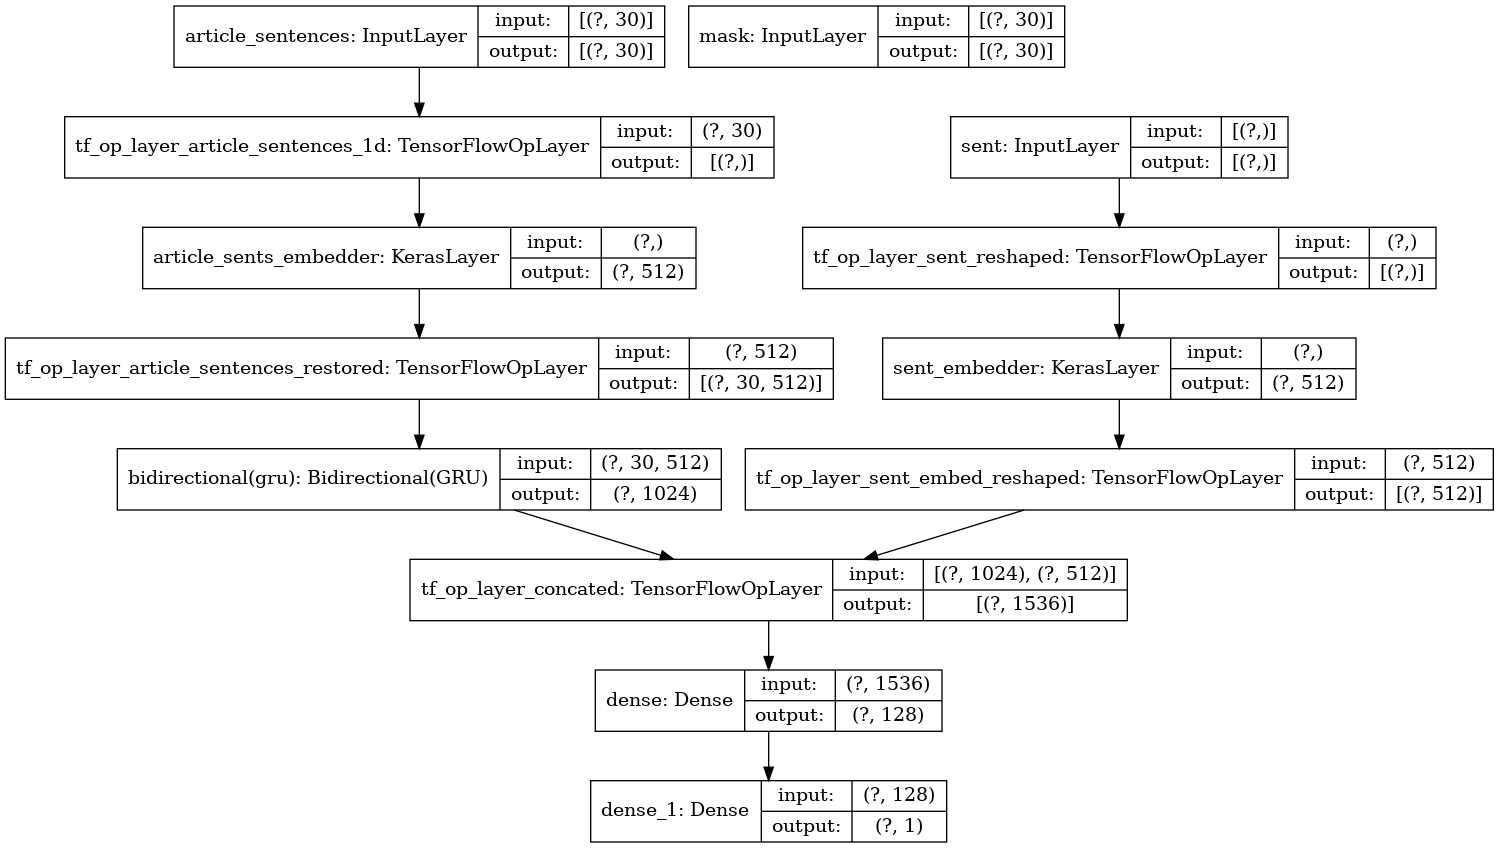

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
checkpoint_filepath = checkpoint_dir
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=5,
                    callbacks=[model_checkpoint_callback],
                    class_weight=class_weights)

Epoch 1/5
17425/17425 [==============================] - ETA: 0s - loss: 0.5479 - binary_accuracy: 0.6497 - recall: 0.7792WARNING:tensorflow:From /home/jzeimen/anaconda3/envs/p36/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: tfmodel.spacy.average_pooling.class_weights/assets


INFO:tensorflow:Assets written to: tfmodel.spacy.average_pooling.class_weights/assets


17425/17425 [==============================] - 5046s 290ms/step - loss: 0.5479 - binary_accuracy: 0.6497 - recall: 0.7792 - val_loss: 0.5946 - val_binary_accuracy: 0.6307 - val_recall: 0.8229
Epoch 2/5
17425/17425 [==============================] - 4995s 287ms/step - loss: 0.5533 - binary_accuracy: 0.6630 - recall: 0.7741 - val_loss: 0.6596 - val_binary_accuracy: 0.6177 - val_recall: 0.8220
Epoch 3/5
17425/17425 [==============================] - ETA: 0s - loss: 0.5962 - binary_accuracy: 0.6637 - recall: 0.7443INFO:tensorflow:Assets written to: tfmodel.spacy.average_pooling.class_weights/assets


INFO:tensorflow:Assets written to: tfmodel.spacy.average_pooling.class_weights/assets


17425/17425 [==============================] - 5019s 288ms/step - loss: 0.5962 - binary_accuracy: 0.6637 - recall: 0.7443 - val_loss: 0.6109 - val_binary_accuracy: 0.6714 - val_recall: 0.7314
Epoch 4/5
17425/17425 [==============================] - 4995s 287ms/step - loss: 0.6333 - binary_accuracy: 0.6589 - recall: 0.7324 - val_loss: 0.6297 - val_binary_accuracy: 0.6531 - val_recall: 0.7537
Epoch 5/5
17425/17425 [==============================] - 4993s 287ms/step - loss: 0.6634 - binary_accuracy: 0.6545 - recall: 0.7253 - val_loss: 0.6998 - val_binary_accuracy: 0.6256 - val_recall: 0.7553


In [16]:
history.history

{'loss': [0.5478658676147461,
  0.5533235669136047,
  0.5962039828300476,
  0.6333487629890442,
  0.6633638143539429],
 'binary_accuracy': [0.6496717929840088,
  0.6630277037620544,
  0.663658082485199,
  0.6589078307151794,
  0.6545377373695374],
 'recall': [0.7791612148284912,
  0.774080216884613,
  0.7442969083786011,
  0.7323778867721558,
  0.7252739667892456],
 'val_loss': [0.5946314930915833,
  0.6596103310585022,
  0.6108503341674805,
  0.6296756267547607,
  0.6997542977333069],
 'val_binary_accuracy': [0.630679726600647,
  0.6177093386650085,
  0.6713985204696655,
  0.6531038284301758,
  0.6255671977996826],
 'val_recall': [0.8229360580444336,
  0.8220049738883972,
  0.7313780188560486,
  0.7537243962287903,
  0.7552762031555176]}

# Predict

In [9]:
model=None
tf.keras.backend.clear_session()
checkpoint_dir

'tfmodel.spacy.average_pooling.class_weights'

In [10]:
saved_model = tf.keras.models.load_model(checkpoint_dir)

In [14]:
# See info here https://spacy.io/models/en#en_core_web_sm
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
nlp = spacy.load('en_core_web_sm')

def predict(sentences, model):
    sentences = sentences[:max_article_length]
    original_length = len(sentences)
    sentences = pad_sents(sentences)
    mask = make_mask(sentences)
    scores = model({"article_sentences":tf.constant([sentences]*max_article_length), 
             "sent":tf.constant(sentences), 
             "mask": tf.constant([mask]*max_article_length)})
    scores = scores.numpy().squeeze()
    return scores, sentences

def predict_top_sents(sentences, model, n=1):
    scores, sentences = predict(sentences, model)
    df = pd.DataFrame({'score': scores, 'sentence': sentences})
    return " ".join(df.nlargest(n,'score').sort_index()['sentence'].values.tolist())

def calculate_rouge(sentences, model, summary, scorer):
    gen_summary = predict_top_sents(sentences, model)
    score = scorer.score(summary, gen_summary)
    return score['rouge1'].fmeasure

def calculate_naive_rouge(sentences, summary, scorer):
    score = scorer.score(summary, " ".join(sentences[:1]))
    return score['rouge1'].fmeasure

def naive_rouge_pd(row):
    row['naive_rouge'] = calculate_naive_rouge(row['sentences'], row['summary'], scorer)
    return row

def rouge_pd(row):
    row['rouge'] = calculate_rouge(row['sentences'], saved_model, row['summary'], scorer)
    return row

In [ ]:
test_dataset = explode_examples(test_data, None, False)
saved_model.evaluate(test_dataset)

In [16]:
test_df = pd.read_parquet(test_data)

In [17]:
from tqdm import tqdm
tqdm.pandas()

/Users/jzeimen/anaconda3/envs/p3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
df = test_df.progress_apply(naive_rouge_pd, axis=1)
df = df.progress_apply(rouge_pd, axis=1)


100%|██████████| 11490/11490 [00:21<00:00, 539.18it/s]


In [28]:
# Rouge_fmeasure is from the best in a greedy search
# rouge is from our precision
# naive_rouge is when we just use the first 3 sentences
df[['rouge_fmeasure', 'rouge', 'naive_rouge']].describe()

,rouge_fmeasure,rouge,naive_rouge
count,11490.000000,11490.000000,11490.000000
mean,0.434478,0.284209,0.267632
std,0.091923,0.124016,0.126278
min,0.094203,0.000000,0.000000
25%,0.370968,0.192308,0.179559
50%,0.426966,0.268657,0.263158
75%,0.487805,0.363636,0.350000
max,1.000000,1.000000,0.840580


In [39]:
row=df.iloc[5]
article = row.sentences.tolist()
article

['This is the moment that a crew of firefighters struggled to haul a giant  pig out of a garden swimming pool.',
 'The prize porker, known  as Pigwig, had fallen into the pool in an upmarket neighbourhood in Ringwood, Hampshire.',
 'His owners had been taking him for a walk around the garden when the animal plunged into the water and was unable to get out.',
 'A team from Dorset Fire and Rescue struggled to haul the huge black pig out of swimming pool water .',
 'The prize porker known as Pigwig had fallen into the water and had then been unable to get out again .',
 'Two fire crews and a specialist animal rescue team had to use slide boards and strops to haul the huge black pig from the small pool.',
 "A spokesman for Dorset Fire and Rescue Service said: 'At 4.50pm yesterday the service received a call to a pig stuck in a swimming pool. '",
 "One crew of firefighters from Ferndown and a specialist animal rescue unit from Poole were mobilised to this incident. '",
 'Once in attendance 

For this article the following is our predicted best sentence to summarize the article.

In [47]:
predict_top_sents(article, saved_model)

"The crew rescued the pig from the swimming pool using specialist animal rescue slide boards, strops and lines to haul the pig from the swimming pool.'"

The actual summary:

In [57]:
print(row.summary)

Giant pig fell into the swimming pool at his home in Ringwood, Hampshire .
It took the efforts of a team of firefighters to winch him out of the water .
A wayward horse also had to be rescued from a swimming pool in Sussex .


And this is what best matched the given summary. 

In [53]:
from itertools import compress
best_possible_match = " ".join(list(compress(row.sentences.tolist(), row.labels.tolist())))
best_possible_match

'Firefighters were also called out to a horse which had fallen into a swimming pool in Heyshott, West Sussex .'

This is how our predicted summary scored compared with the actual summary

In [55]:
scorer.score(row.summary, predict_top_sents(article, saved_model))

{'rouge1': Score(precision=0.4230769230769231, recall=0.2558139534883721, fmeasure=0.3188405797101449)}

And this is with the best sentence possible. 

In [56]:
scorer.score(row.summary, best_possible_match)

{'rouge1': Score(precision=0.6842105263157895, recall=0.3023255813953488, fmeasure=0.41935483870967744)}